# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**

**Признаки**  
RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента  
Surname — фамилия  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — сколько лет человек является клиентом банка  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  

**Целевой признак**  
Exited — факт ухода клиента

## Подготовка данных

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import warnings

In [67]:
data = pd.read_csv('/datasets/Churn.csv')
r_s = 12345
warnings.filterwarnings('ignore')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [69]:
# колонки 'RowNumber', 'CustomerId', 'Surname' не важны для построения нашей модели
# уберем их из наших данных
df = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [70]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [71]:
# так как распределенией по годам примерно одинаковое, заполнение NAN средним или медианой приведет к перекосу в данных
# так как количество NAN не превышает 10% от нашей выборки - удалим эти строки из наших данных
df=df.dropna()

In [72]:
# смотрим уникальные значения Geography
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [73]:
# получаем дамми-признаки, избегая дамми-ловушки
df_geography = pd.get_dummies(df['Geography'], drop_first=True)
df_gender = pd.get_dummies(df['Gender'], drop_first=True)
# добавляем получившиеся данные в наш dataset
df = pd.concat([df, df_geography, df_gender], axis=1)
# удаляем ненужные теперь столбцы
df = df.drop(['Geography', 'Gender'], axis=1)

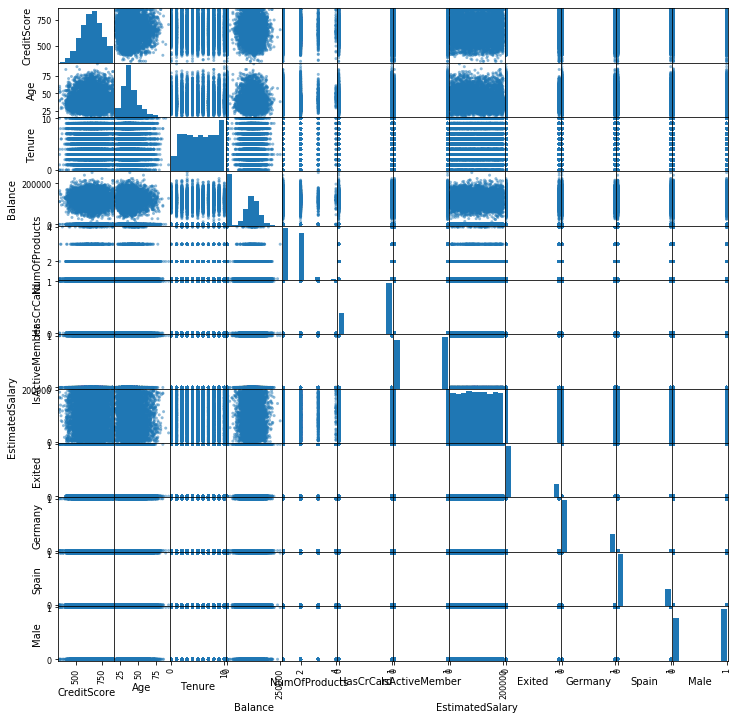

In [74]:
#построим графики для проверки мультиколлинеарности
pd.plotting.scatter_matrix(df, figsize=(12, 12));

In [75]:
#стандартизируем количественные признаки
#numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
#scaler = StandardScaler()
#scaler.fit(df[numeric])  
#df[numeric] = scaler.transform(df[numeric])

In [76]:
#подготовим выборки
df_features = df.drop(['Exited'], axis=1) 
df_targets = df['Exited']
features, features_valid, targets, targets_valid = train_test_split(
    df_features, df_targets, test_size = 0.4, random_state=r_s)
features_test, features_valid, targets_test, targets_valid = train_test_split(
    features_valid, targets_valid, test_size = 0.5, random_state=r_s)

In [77]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features[numeric])
features[numeric] = scaler.transform(features[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Вывод:  
- загрузили и оценили данные - имеются пропуски в столбце 'Tenure'
- убрали из наших данных колонки 'RowNumber', 'CustomerId', 'Surname', так как для построения нашей модели они не нужны
- так как распределение в данных "сколько лет человек является клиентом банка" примерно одинаковое по годам и доля Nan в наших данных не превышает 10% - удаляем эти строки с пропусками из нашей выборки
- построили графики для проверки мультиколлинеарности
- на графиках видно, что в данных нет явной корреляции, следовательно они не мультиколлинеарны - оставляем данные без изменений
- получили дамми-призники признаков 'Geography' и 'Gender', избавились от фиктивных признаков
- масштабировали количественные признаки методом стандартизации данных
- разбили данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 для последующего моделирования

## Исследование задачи

Обучим модели без учета дисбаланса классов

In [78]:
#проверим баланс исходных данных
frequency = df['Exited'].value_counts(normalize=True)
frequency

0    0.796062
1    0.203938
Name: Exited, dtype: float64

### Дерево решений

In [79]:
max_depth = 0
f1 = 0
auc = 0
for i in range(1, 21, 1):
    model_tree = DecisionTreeClassifier(max_depth=i, random_state=r_s)
    model_tree.fit(features, targets)
    predicted = model_tree.predict(features_valid)
    if f1 < f1_score(targets_valid, predicted):
        f1 = f1_score(targets_valid, predicted)
        auc = roc_auc_score(targets_valid, model_tree.predict_proba(features_valid)[:,1])
        max_depth = i
print('Глубина дерева =', max_depth, 'F1_score:', f1, 'AUC-ROC', auc)

Глубина дерева = 7 F1_score: 0.5534804753820034 AUC-ROC 0.8280166825807154


### Случайный лес

In [80]:
max_depth = 0
forest = 0
f1 = 0
auc = 0
for i in range(1, 21, 1):
    for n in range(1, 21, 1):
        model_forest = RandomForestClassifier(n_estimators=i, max_depth=n, random_state=r_s)
        model_forest.fit(features, targets)
        predicted = model_forest.predict(features_valid)
        if f1 < f1_score(targets_valid, predicted):
            f1 = f1_score(targets_valid, predicted)
            auc = roc_auc_score(targets_valid, model_forest.predict_proba(features_valid)[:,1])
            forest = i 
            max_depth = n
print('Количество деревьев', forest, 'Глубина дерева =', max_depth  , 'F1_score:', f1, 'AUC-ROC', auc)

Количество деревьев 17 Глубина дерева = 13 F1_score: 0.5944055944055944 AUC-ROC 0.8363705877329856


### Логистическая регрессия

In [81]:
model_log = LogisticRegression(solver='liblinear', random_state=r_s) 
model_log.fit(features, targets)
predicted = model_log.predict(features_valid)
print('F1_score:', f1_score(targets_valid, predicted), 'AUC-ROC', roc_auc_score(targets_valid,
                                                                                model_log.predict_proba(features_valid)[:,1]))

F1_score: 0.3175965665236052 AUC-ROC 0.780939239386106


### Вывод:
- наши данные сильно расбалансированы, 79,6% респондентов остались клиентом банка, 20,4% - ушли из банка
- по условиям задания, найдем модель с учетом дисбаланса
- наилучшей моделью является "Случайный лес" с количеством деревьев 17 и глубиной 10
- метрика F1 для этой модели выдает 0,5921, что немнгого превышает нашу цель в 0,59
- AUC-ROC при этом равен 0,8566, что говорит о том что модель достаточно хорошо различает классы
- наихудшая модель - логистическая регрессия, показатель F1 - всего 0,3176

## Борьба с дисбалансом

Сбалансируем наши данные, придав объектам редкого класса 1 больший вес

### Дерево решений (balanced)

In [82]:
max_depth = 0
f1 = 0
auc = 0
for i in range(1, 21, 1):
    model_tree_balanced = DecisionTreeClassifier(max_depth=i, random_state=r_s, class_weight='balanced')
    model_tree_balanced.fit(features, targets)
    predicted = model_tree_balanced.predict(features_valid)
    if f1 < f1_score(targets_valid, predicted):
        f1 = f1_score(targets_valid, predicted)
        auc = roc_auc_score(targets_valid, model_tree_balanced.predict_proba(features_valid)[:,1])
        max_depth = i
print('Глубина дерева =', max_depth, 'F1_score:', f1, 'AUC-ROC', auc)

Глубина дерева = 5 F1_score: 0.5653631284916201 AUC-ROC 0.8374962155616106


### Случайный лес (balanced)

In [83]:
max_depth = 0
forest = 0
f1 = 0
auc = 0
for i in range(1, 21, 1):
    for n in range(1, 21, 1):
        model_forest_balanced = RandomForestClassifier(n_estimators=i, max_depth=n, random_state=r_s, class_weight='balanced')
        model_forest_balanced.fit(features, targets)
        predicted = model_forest_balanced.predict(features_valid)
        if f1 < f1_score(targets_valid, predicted):
            f1 = f1_score(targets_valid, predicted)
            auc = roc_auc_score(targets_valid, model_forest_balanced.predict_proba(features_valid)[:,1])
            forest = i 
            max_depth = n
print('Количество деревьев', forest, 'Глубина дерева =', max_depth  , 'F1_score:', f1, 'AUC-ROC', auc)

Количество деревьев 13 Глубина дерева = 8 F1_score: 0.6035353535353535 AUC-ROC 0.8467515933455987


### Логистическая регрессия (balanced)

In [84]:
model_log_balanced = LogisticRegression(solver='liblinear', random_state=r_s, class_weight='balanced') 
model_log_balanced.fit(features, targets)
predicted = model_log_balanced.predict(features_valid)
print('F1_score:', f1_score(targets_valid, predicted), 'AUC-ROC', roc_auc_score(
    targets_valid, model_log_balanced.predict_proba(features_valid)[:,1]))

F1_score: 0.5025432349949135 AUC-ROC 0.7817621121435836


Сбалансируем наши данные, увеличив выборку

In [85]:
def upsample (features, target, repeat):
    features_zero = features[target == 0]
    features_ones = features[target == 1]
    target_zero = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zero] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zero] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle (features_upsampled, target_upsampled, random_state = r_s)
    return features_upsampled, target_upsampled

In [86]:
# количество 0 больше количества 1 примерно в 4 раза, увеличим нашу выборку на данное значение
features_upsampled, target_upsampled = upsample (features, targets, 4)

### Дерево решений (upsampling)

In [87]:
max_depth = 0
f1 = 0
auc = 0
for i in range(1, 21, 1):
    model_tree_upsampling = DecisionTreeClassifier(max_depth=i, random_state=r_s)
    model_tree_upsampling.fit(features_upsampled, target_upsampled)
    predicted = model_tree_upsampling.predict(features_valid)
    if f1 < f1_score(targets_valid, predicted):
        f1 = f1_score(targets_valid, predicted)
        auc = roc_auc_score(targets_valid, model_tree_upsampling.predict_proba(features_valid)[:,1])
        max_depth = i
print('Глубина дерева =', max_depth, 'F1_score:', f1, 'AUC-ROC', auc)

Глубина дерева = 5 F1_score: 0.5653631284916201 AUC-ROC 0.8374962155616106


### Случайный лес (upsampling)

In [88]:
max_depth = 0
forest = 0
f1 = 0
auc = 0
for i in range(1, 21, 1):
    for n in range(1, 21, 1):
        model_forest_upsampling = RandomForestClassifier(n_estimators=i, max_depth=n, random_state=r_s)
        model_forest_upsampling.fit(features_upsampled, target_upsampled)
        predicted = model_forest_upsampling.predict(features_valid)
        if f1 < f1_score(targets_valid, predicted):
            f1 = f1_score(targets_valid, predicted)
            auc = roc_auc_score(targets_valid, model_forest_upsampling.predict_proba(features_valid)[:,1])
            forest = i 
            max_depth = n
print('Количество деревьев', forest, 'Глубина дерева =', max_depth  , 'F1_score:', f1, 'AUC-ROC', auc)

Количество деревьев 19 Глубина дерева = 19 F1_score: 0.6183431952662722 AUC-ROC 0.8380289480425719


### Логистическая регрессия (upsampling)

In [89]:
model_log_upsampling = LogisticRegression(solver='liblinear', random_state=r_s) 
model_log_upsampling.fit(features_upsampled, target_upsampled)
predicted = model_log_upsampling.predict(features_valid)
print('F1_score:', f1_score(targets_valid, predicted), 'AUC-ROC', roc_auc_score(
    targets_valid, model_log_upsampling.predict_proba(features_valid)[:,1]))

F1_score: 0.49653808110781406 AUC-ROC 0.7817349418166857


Сбалансируем наши данные, уменьшив выборку

In [90]:
def downsample (features, target, fraction):
    features_zero = features[target == 0]
    features_ones = features[target == 1]
    target_zero = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zero.sample(frac=fraction, random_state=r_s)] + [features_ones])
    target_downsampled = pd.concat([target_zero.sample(frac=fraction, random_state=r_s)] + [target_ones])
    features_downsampled, target_downsampled = shuffle (features_downsampled, target_downsampled, random_state = r_s)
    return features_downsampled, target_downsampled

In [91]:
# количество 1 меньше количества 0 примерно в 0,26 раз, уменьшим нашу выборку на данное значение
features_downsampled, target_downsampled = downsample (features, targets, 0.26)

### Дерево решений (downsampling)

In [92]:
max_depth = 0
f1 = 0
auc = 0
for i in range(1, 21, 1):
    model_tree_downsampling = DecisionTreeClassifier(max_depth=i, random_state=r_s)
    model_tree_downsampling.fit(features_downsampled, target_downsampled)
    predicted = model_tree_downsampling.predict(features_valid)
    if f1 < f1_score(targets_valid, predicted):
        f1 = f1_score(targets_valid, predicted)
        auc = roc_auc_score(targets_valid, model_tree_downsampling.predict_proba(features_valid)[:,1])
        max_depth = i
print('Глубина дерева =', max_depth, 'F1_score:', f1, 'AUC-ROC', auc)

Глубина дерева = 7 F1_score: 0.5581896551724137 AUC-ROC 0.8262137373172795


### Случайнгый лес (downsampling)

In [93]:
max_depth = 0
forest = 0
f1 = 0
auc = 0
for i in range(1, 21, 1):
    for n in range(1, 21, 1):
        model_forest_downsampling = RandomForestClassifier(n_estimators=i, max_depth=n, random_state=r_s)
        model_forest_downsampling.fit(features_downsampled, target_downsampled)
        predicted = model_forest_downsampling.predict(features_valid)
        if f1 < f1_score(targets_valid, predicted):
            f1 = f1_score(targets_valid, predicted)
            auc = roc_auc_score(targets_valid, model_forest_downsampling.predict_proba(features_valid)[:,1])
            forest = i 
            max_depth = n
print('Количество деревьев', forest, 'Глубина дерева =', max_depth  , 'F1_score:', f1, 'AUC-ROC', auc)

Количество деревьев 16 Глубина дерева = 20 F1_score: 0.5772972972972973 AUC-ROC 0.849302692967543


### Логистическая регрессия (downsampling)

In [94]:
model_log_downsampling = LogisticRegression(solver='liblinear', random_state=r_s) 
model_log_downsampling.fit(features_downsampled, target_downsampled)
predicted = model_log_downsampling.predict(features_valid)
print('F1_score:', f1_score(targets_valid, predicted), 'AUC-ROC', roc_auc_score(
    targets_valid, model_log_downsampling.predict_proba(features_valid)[:,1]))

F1_score: 0.492462311557789 AUC-ROC 0.7809159505344792


### Вывод:
- после устранения дисбаланса качество модели выросло в случаях балансировки через весы и увеличение выборки
- при уменьшении выборки качество моделей да же в ряде случаев ухудшилось
- особенно это заметно на Логистической регресии - увеличение показателя F1 c 0.3176 до 0.503
- наилучшей моделю так же осталась "Случайный лес" во всех случаях
- наиболее качественной моделью является "Случайный лес" при методе балансировки "Уведличение выборки" с количеством деревьев 19 и глубиной 19
- показатель F1 нашей лучшей модели 0.6183, что выше порогового значения 0,59
- покзатель AUC-ROC несколько хуже чем у не сбалансированной модели, однако все еще остается достаточно высоким
<code>Модель                     |Метрика | НЕсбалансированные данные  |Balanced              |Upsampling          |Downsampling
:------------------------- | :----: | :------------------------: | :------------------: | :----------------: | ---------------:
Дерево решений             |F1      |0.5534804753820034          |0.5653631284916201    |0.5653631284916201  |0.5581896551724137
Дерево решений             |AUC-ROC |0.8280166825807154          |0.8374962155616106    |0.8374962155616106  |0.8262137373172795
Случайный лес              |F1      |0.5944055944055944          |0.6035353535353535    |0.6183431952662722  |0.5772972972972973
Случайный лес              |AUC-ROC |0.8363705877329856          |0.8467515933455987    |0.8380289480425719  |0.8493026929675430
Логистическая регрессия    |F1      |0.3175965665236052          |0.5025432349949135    |0.49653808110781406  |0.492462311557789
Логистическая регрессия    |AUC-ROC |0.7809392393861060          |0.7817621121435836    |0.7817349418166857  |0.7809159505344792
    
</code>


## Тестирование модели

In [95]:
# Наша лучшая модель "Случайный лес" отбалансированная методом upsampled, с количеством деревьев и глубиной = 19
model_forest_upsampling_test = RandomForestClassifier(n_estimators=19, max_depth=19, random_state=r_s)
model_forest_upsampling_test.fit(features_upsampled, target_upsampled)
predicted = model_forest_upsampling_test.predict(features_test)
print('F1_score:', f1_score(targets_test, predicted), 'AUC-ROC', roc_auc_score(
    targets_test, model_forest_upsampling_test.predict_proba(features_test)[:,1]))

F1_score: 0.6049204052098409 AUC-ROC 0.8399330335366135


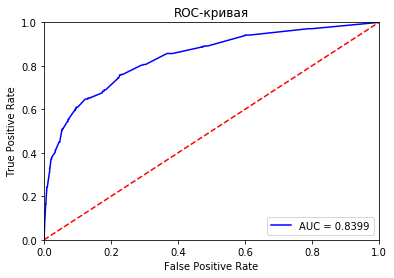

In [96]:
probs = model_forest_upsampling_test.predict_proba(features_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(targets_test, preds)
roc_auc = roc_auc_score(targets_test, preds)
plt.title('ROC-кривая')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Вывод:
- Метрика F1 тестовой модели ниже, чем метрика валидационной - 0,6049 против 0,6183
- однако значение больше порогового 0.59, 
- AUC-ROC тестовой модели выше, чем у валидационной
- и в том и другом случае показатели данной метрики высокие, что говориит о том, что модель хорошо различает классы
- таким образом можно сделать вывод о адекватности и работоспособности модели в рамках поставленной задачи